In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

import matplotlib.pyplot as plt
import seaborn as sns
from figurefirst import 
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc

import pandas as pd
import os
import numpy as np

from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ProcessPoolExecutor

from joblib import load, dump

In [34]:
# Save the trained model to a file
# dump(trained_models, '../assets/models/gp_model_90_partialdata_ensemblekernel_2023Nov2.joblib')


# Load the trained_models dictionary from the file
# trained_models = load('../assets/models/gpNov22diag17.joblib')

### Gaussian Processes

In [11]:
# def train_gp_for_file(file_path):
#     # Load the data
#     df = pd.read_hdf(file_path)
    
#     x_min, x_max = df['distance_along_streakline'].min(), df['distance_along_streakline'].max()

#     window_size_x=5.0
#     step_size=1
    
#     pdf_values=[]
    
    
#     for x_start in np.arange(x_min, x_max, step_size):
#         # Define the window range in the x dimension
#         x_end = x_start + window_size_x

#         # Filter the data points that are within the current sliding window
#         window_df = df[(df['distance_along_streakline'] >= x_start) & 
#                     (df['distance_along_streakline'] < x_end)]

#          # Proceed if there are enough data points for KDE
#         if len(window_df) > 1:
#             # Check the variance to ensure it's not too low
#             if np.var(window_df['odor'].values) > 1e-8:  # This threshold can be adjusted
#                 try:
#                     # Perform KDE on the odor measurements within the window
#                     kde = gaussian_kde(window_df['odor'].values, bw_method='silverman')
#                     # Evaluate the KDE for a range of odor values
#                     odor_range = np.linspace(window_df['odor'].min(), window_df['odor'].max(), 100)
#                     pdf = kde(odor_range)

#                     # mean of the PDF values for this window
#                     pdf_values.append({'x_center': x_start + window_size_x / 2, 'pdf_mean': np.mean(pdf)})
#                 except np.linalg.LinAlgError:
#                     print(f"Singular matrix encountered at window starting at {x_start}.") # Handle the singular matrix case
#             else:
#                 # print(f"Variance too low at window starting at {x_start}.")
#                 continue

    
#     # Check if we have any PDF values computed
#     if not pdf_values:
#         raise ValueError("No KDE computations were successful; possibly not enough data.")

#     # Prepare the training data for the GP regressor
#     X_train = np.array([[item['x_center']] for item in pdf_values])
#     y_train = np.array([item['pdf_mean'] for item in pdf_values])

#     # Define the GP kernel
#     kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

#     # Initialize and train the GP regressor
#     gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
#     gp.fit(X_train, y_train)

#     return gp, file_path

# # Modify the folder path as needed
# folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
# all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# trained_models = {}

# num_cores = 40  # Adjust based on your system
# with ProcessPoolExecutor(max_workers=num_cores) as executor:
#     results = executor.map(train_gp_for_file, all_files)
    
#     for result in results:
#         if result is not None:
#             gp_model, file_path = result
#             trained_models[file_path] = gp_model
#             # print(f"Trained GP model for file {file_path}.")
# print("Done")

/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian

Done


In [13]:
# def process_with_sliding_window(df, x_min, x_max, window_size_x, step_size):
#     pdf_values = []

#     for x_start in np.arange(x_min, x_max, step_size):
#         x_end = x_start + window_size_x
#         window_df = df[(df['distance_along_streakline'] >= x_start) & 
#                        (df['distance_along_streakline'] < x_end)]
#         if len(window_df) > 1 and np.var(window_df['odor'].values) > 1e-8:
#             kde = gaussian_kde(window_df['odor'].values, bw_method='silverman')
#             odor_range = np.linspace(window_df['odor'].min(), window_df['odor'].max(), 100)
#             pdf = kde(odor_range)
#             pdf_values.append({'x_center': x_start + window_size_x / 2, 'pdf_mean': np.mean(pdf)})
#     return pdf_values

In [33]:
# test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag1.h5"
# test_df = pd.read_hdf(test_file_path)

# x_min, x_max = test_df['distance_along_streakline'].min(), test_df['distance_along_streakline'].max()

# window_size_x = 5 
# step_size = 1 

# test_pdf_values = process_with_sliding_window(test_df, x_min, x_max, window_size_x, step_size)


# X_test = np.array([[item['x_center']] for item in test_pdf_values])
# y_test_true = np.array([item['pdf_mean'] for item in test_pdf_values])  # The true values from the test data


# gp_model=trained_models["/home/beast/An/data/Sept13Plumes/plume1/train/diag23.h5"]

# # Make predictions on the test data using the GP model
# y_pred_mean, y_pred_std = gp_model.predict(X_test, return_std=True)

# # If you need to predict for a specific x value, say x_new, you can do:
# x_new = 15.0  # example new x value
# y_new_pred, y_new_std = gp_model.predict(np.array([[x_new]]), return_std=True)

# # Output the predicted mean PDF and standard deviation at x_new
# print(f"Predicted mean PDF at x={x_new}: {y_new_pred[0]}")
# print(f"Standard deviation of prediction at x={x_new}: {y_new_std[0]}")

# f,ax=plt.subplots(1,1,figsize=(6,5))
# ax.errorbar(X_test.flatten(), y_pred_mean, yerr=y_pred_std, fmt='o', label='Predictions with Uncertainty')
# ax.scatter(X_test.flatten(), y_test_true, color='red', label='True Values', alpha=0.5)
# ax.set_xlabel('Distance Along Streakline')
# ax.set_ylabel('PDF Mean')
# ax.set_title('Comparison of True and Predicted PDF Means')
# ax.legend(loc='upper left')
# mpl_functions.set_fontsize(ax, 12)

### Continuous values prediction

In [2]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    # Load the data
    df = pd.read_hdf(file_path)
    
    # Subsample the data for faster training 
    data_subsample = df.sample(frac=1)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor'].values  
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
    gp.fit(X, y)
    
    return gp, file_path

# Modify the folder path as needed
folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}

num_cores = 60  # Adjust based on your system
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, file_path in results:
        trained_models[file_path] = gp_model

print("Done")

/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_proces

Done


### On Train Data

Mean Squared Error: 0.0191406917764485
Root Mean Squared Error: 0.1383498889643519
Mean Absolute Error: 0.053153616263586084
R-squared: 0.9755864595902042


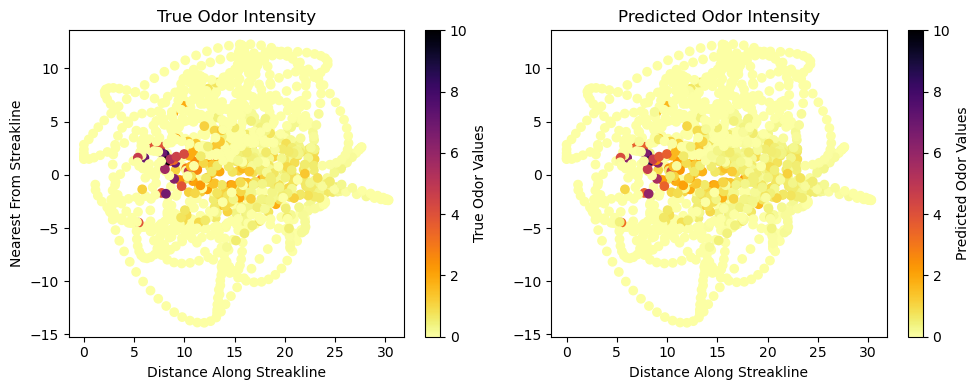

In [39]:
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor'].values  # Use continuous odor values

# Make predictions using the retrieved GP model
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)

# Regression Metrics
mse = mean_squared_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred_mean)
r2 = r2_score(y_true, y_pred_mean)

# Printing the Metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


# Assuming y_pred_mean contains the continuous predicted odor values
y_pred_continuous = y_pred_mean  # Replace with your actual predictions

f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno_r', vmin=0,vmax=10)  # Use actual odor values
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_continuous, cmap='inferno_r',vmin=0,vmax=10)  # Use continuous predicted values
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

In [40]:
x=pd.read_hdf('/home/beast/An/data/Sept13Plumes/plume1/train_raw/diag17.h5')
def calculate_distance_from_source(df):
    source = np.array([[0,0]])
    odor_position = np.array([[df.x[i],df.y[i]] for i in range (len(df))]) 

    distance_from_source = np.array([cdist(odor_position,source)]).flatten()
    df['distance_from_source'] = distance_from_source
    
    
calculate_distance_from_source(x)

In [41]:
osc.get_time_col(test_df,0.3)

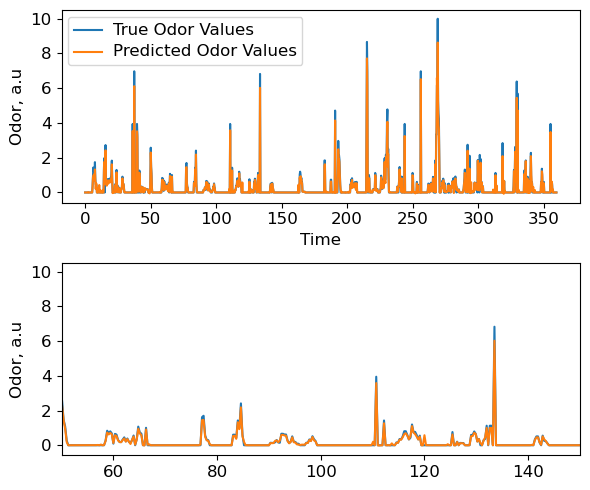

In [42]:
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 5))

ax1.plot(test_df.time, test_df.odor, label ='True Odor Values')
ax1.plot(test_df.time, y_pred_continuous, label= 'Predicted Odor Values')
ax1.set_ylabel('Odor, a.u')
ax1.set_xlabel('Time')
ax1.legend()
mpl_functions.set_fontsize(ax1, 14)

ax2.plot(test_df.time, test_df.odor, label ='True Odor Values')
ax2.plot(test_df.time, y_pred_continuous, label= 'Predicted Odor Values')
ax2.set_ylabel('Odor, a.u')
# ax2.set_xlabel('Time')
# ax2.legend()
ax2.set_xlim([50, 150])
mpl_functions.set_fontsize(ax2, 12)
f.tight_layout()

In [43]:
store = np.array(x.distance_from_source.iloc[100:])
test_df['distance_from_source']=store

In [44]:
test_df['predicted_odor']=y_pred_continuous

In [45]:
def mean_conc(df,index,dat):
    #Distance
    i = 0
    mean_concentration = []
    while i<len(index):
        mean_concentration.append(np.mean(df.odor[index[i]])) 
        i+=1
    dat['mean_concentration']=mean_concentration

def cal_stat(df,index, index_predicted,fdf, fdf_predicted):
    osc.avg_distance(df,index,fdf)
    osc.whiff_blank_duration(df,index,fdf)
    mean_conc(df,index,fdf)
    
    osc.avg_distance(df,index_predicted,fdf_predicted)
    osc.whiff_blank_duration(df,index_predicted,fdf_predicted)
    
    osc.predicted_mean_conc(df,index_predicted,fdf_predicted)

np.seterr(divide='ignore')
index = osc.get_index(test_df.odor,0.5)
index_predicted = osc.get_index(test_df.predicted_odor,0.5)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(test_df,index,index_predicted,fdf, fdf_predicted)

fdf.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'length_of_encounter', 'odor_intermittency', 'log_whiff', 'log_blank',
       'mean_concentration'],
      dtype='object')

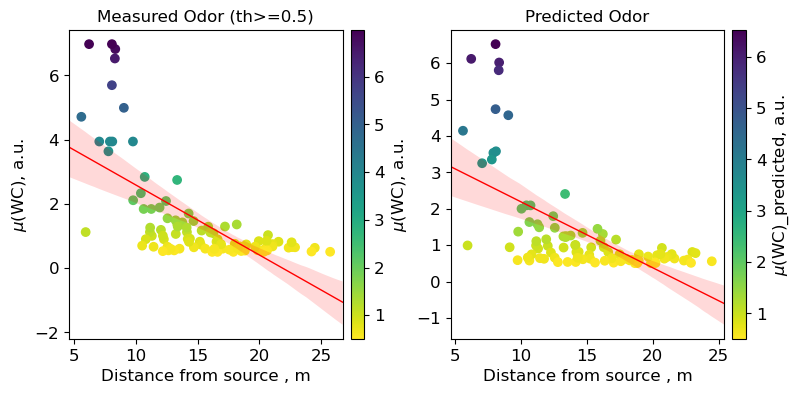

In [46]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')


g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.mean_concentration , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax1.set_title('Measured Odor (th>=0.5)')

u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration_p, 
              c=fdf_predicted.mean_concentration_p, cmap='viridis_r' )
# ax2.set_ylabel('Whiff Concentration, a.u.')


g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.mean_concentration_p , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

ax2.set_xlabel('Distance from source , m')
# ax2.set_ylabel('$\mu$(WC), a.u.')
ax2.set_title('Predicted Odor')
f.tight_layout(pad=1)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

In [50]:
fdf.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'length_of_encounter', 'odor_intermittency', 'log_whiff', 'log_blank',
       'mean_concentration'],
      dtype='object')

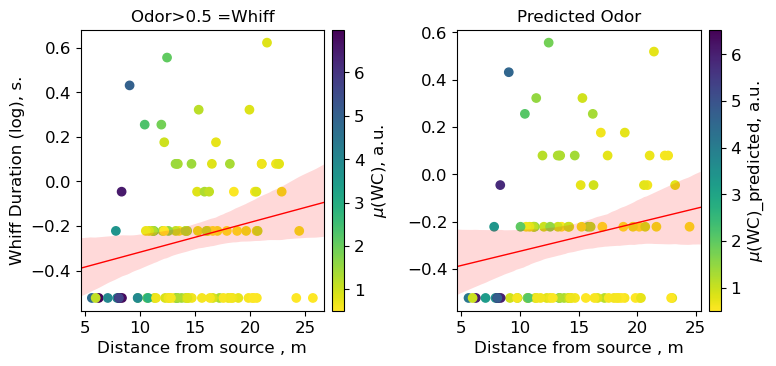

In [57]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.log_whiff, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.log_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('Whiff Duration (log), s.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration_p, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

### Test Data

-0.7513569706718934


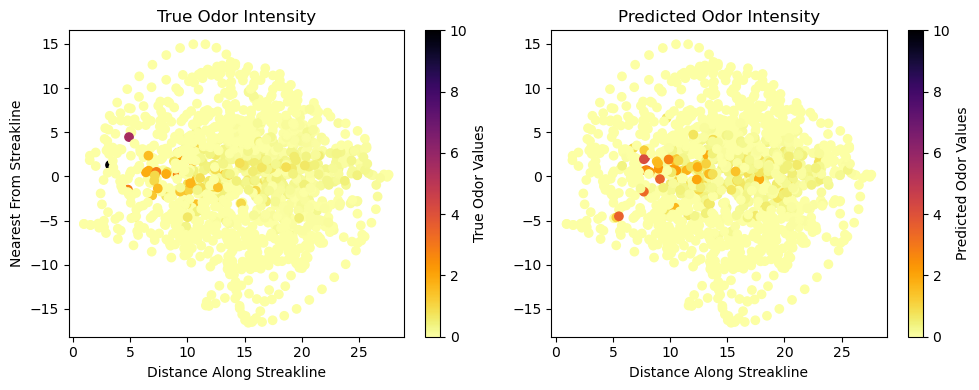

In [29]:
# Choose a representative trained model
representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5"
gp_representative = trained_models[representative_file_path]

# Path to the new test file
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag1.h5"
test_df = pd.read_hdf(test_file_path)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor'].values

y_pred_mean, y_pred_std = gp_representative.predict(X_test, return_std=True)

# Regression Metrics
mse = mean_squared_error(y_true, y_pred_mean)
mae = mean_absolute_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_mean)

print(r2)
# Setting the same scale for color bars
vmin = min(y_true.min(), y_pred_mean.min())
vmax = max(y_true.max(), y_pred_mean.max())

f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno_r', vmin=0, vmax=10)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_mean, cmap='inferno_r', vmin=0, vmax=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

plt.show()

### Using Cross Validation - Train Test Split

In [ ]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    df = pd.read_hdf(file_path)

    data_subsample = df.sample(frac=0.9)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor'].values

    n_splits = 5
    kf = KFold(n_splits=n_splits)

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)

    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        gp.fit(X_train, y_train)
        y_pred = gp.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))

    avg_mse = np.mean(mse_scores)
    print(f"Average MSE for {file_path}: {avg_mse}")
    gp.fit(X, y)
    
    return gp, file_path, avg_mse

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]


trained_models = {}
avg_mse_values = {}  

num_cores = 10  
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, file_path, avg_mse in results:
        trained_models[file_path] = gp_model
        avg_mse_values[file_path] = avg_mse 
for file_path, mse in avg_mse_values.items():
    print(f"Average MSE for {file_path}: {mse}")

print("Training Complete")

In [ ]:
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag49.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor'].values  # Use continuous odor values

# Make predictions using the retrieved GP model
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)

# Regression Metrics
mse = mean_squared_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred_mean)
r2 = r2_score(y_true, y_pred_mean)

# Printing the Metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Assuming y_pred_mean contains the continuous predicted odor values
y_pred_continuous = y_pred_mean  # Replace with your actual predictions

f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno_r')  # Use actual odor values
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_continuous, cmap='inferno_r')  # Use continuous predicted values
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

### On Test Data

In [ ]:
# Choose a representative trained model
representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag49.h5"
gp_representative = trained_models[representative_file_path]

# Path to the new test file
test_file_path = "/home/an/dataAnalysis/data/Sept13Plumes/plume1/test/diag10.h5"
test_df = pd.read_hdf(test_file_path)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor'].values

y_pred_mean, y_pred_std = gp_representative.predict(X_test, return_std=True)

# Regression Metrics
mse = mean_squared_error(y_true, y_pred_mean)
mae = mean_absolute_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_mean)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

y_pred_continuous = y_pred_mean  # Replace with your actual predictions

f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno')  # Use actual odor values
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_continuous, cmap='inferno')  # Use continuous predicted values
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

### Binary value prediction

In [4]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    # Load the data
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    # Subsample the data for faster training 
    data_subsample = df.sample(frac=0.9)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor_binary'].values  
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Scale the features
    X_scaled = scaler.fit_transform(X)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
    gp.fit(X_scaled, y)
    
    return gp, scaler, file_path

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
scalers = {}

num_cores = 40
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, scaler, file_path in results:
        trained_models[file_path] = gp_model
        scalers[file_path] = scaler
        # print(f"Completed training for file: {file_path}")
print("Done")

/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/

Done


### Predict the odor values for the seen data

Accuracy: 0.7078571428571429
Classification report:               precision    recall  f1-score   support

           0       0.73      0.93      0.82       984
          10       0.52      0.19      0.27       416

    accuracy                           0.71      1400
   macro avg       0.63      0.56      0.55      1400
weighted avg       0.67      0.71      0.66      1400



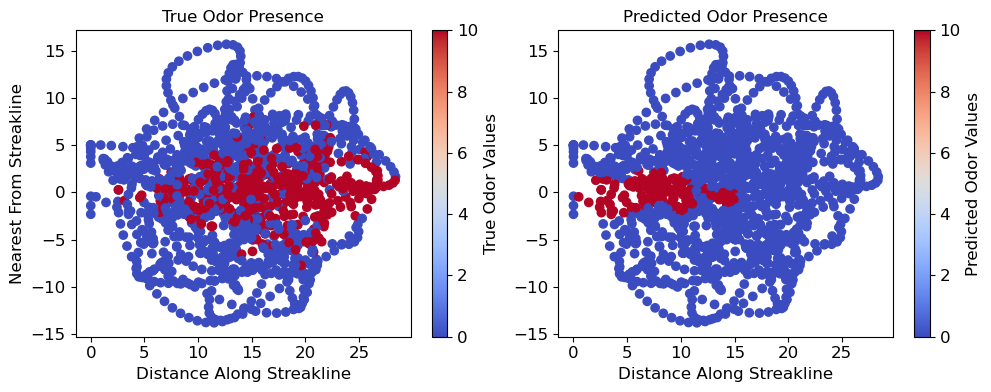

In [8]:
# Testing phase
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor_binary'].values

# Make predictions using the retrieved GP model
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)
y_pred_binary = np.where(y_pred_mean > 0.1, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")
print(f"Classification report: {report}")

f, axes = plt.subplots(1,2, figsize=(10, 4))

sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')


sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')
# axes[1].set_ylabel('Nearest From Streakline')

f.tight_layout()

mpl_functions.set_fontsize(f, 12)

### Prediction on a new data point with new plume

Accuracy: 0.8246153846153846
Classification report:               precision    recall  f1-score   support

           0       0.88      0.86      0.87       859
          10       0.73      0.76      0.75       441

    accuracy                           0.82      1300
   macro avg       0.80      0.81      0.81      1300
weighted avg       0.83      0.82      0.83      1300



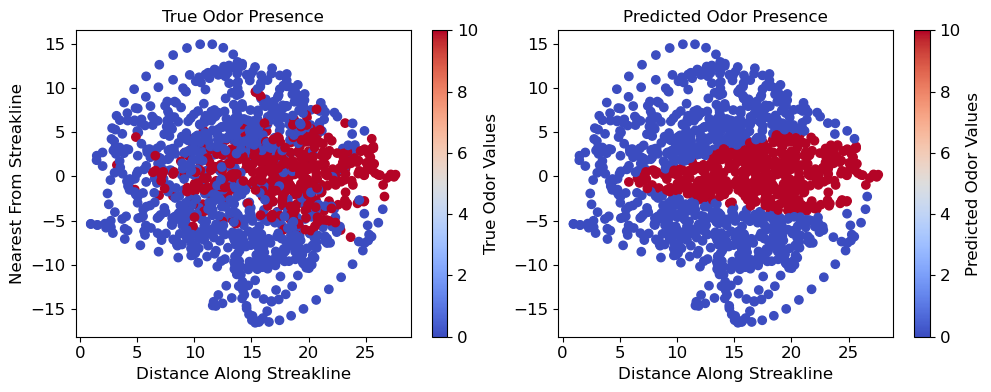

In [23]:
# Choose a representative trained model
representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag15.h5"  # Modify this to an actual training file path
gp_representative = trained_models[representative_file_path]

# Path to the new test file
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag1.h5"
test_df = pd.read_hdf(test_file_path)

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor_binary'].values


y_pred_mean, y_pred_std = gp_representative.predict(X_test, return_std=True)
y_pred_binary = np.where(y_pred_mean > 4.5, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")
print(f"Classification report: {report}")

f, axes = plt.subplots(1, 2, figsize=(10, 4))


sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')


sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

mpl_functions.set_fontsize(f, 12)

#### Using a average representation of the system ( not great )

In [17]:
# test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag1.h5"
# test_df = pd.read_hdf(test_file_path)

# if 'odor_binary' not in test_df.columns:
#     test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
# y_true = test_df['odor_binary'].values

# # Collect predictions from all trained models
# all_predictions = []

# for gp_model in trained_models.values():
#     y_pred_mean, _ = gp_model.predict(X_test, return_std=True)
#     y_pred_binary = np.where(y_pred_mean > 0, 10, 0)
#     all_predictions.append(y_pred_binary)

# # Average the predictions (or take a majority vote)
# # Here we're using the mean; you can also use other aggregation methods
# final_prediction = np.mean(all_predictions, axis=0)
# final_prediction_binary = np.where(final_prediction > 0, 10, 0)

# accuracy = accuracy_score(y_true, final_prediction_binary)
# print(f"Accuracy using all trained models: {accuracy}")


# f, axes = plt.subplots(1, 2, figsize=(10, 4))

# mask = test_df['odor_binary'] >= 0
# sc1 = axes[0].scatter(test_df['distance_along_streakline'][mask], test_df['nearest_from_streakline'][mask], 
#                       c=test_df['odor_binary'][mask], cmap='Blues')
# cbar1 = plt.colorbar(sc1, ax=axes[0])
# cbar1.set_label('True Odor Values')
# axes[0].set_title('True Odor Presence')
# axes[0].set_xlabel('Distance Along Streakline')
# axes[0].set_ylabel('Nearest From Streakline')

# mask_pred = y_pred_binary >= 0
# sc2 = axes[1].scatter(test_df['distance_along_streakline'][mask_pred], test_df['nearest_from_streakline'][mask_pred], 
#                       c=y_pred_binary[mask_pred], cmap='Blues')
# cbar2 = plt.colorbar(sc2, ax=axes[1])
# cbar2.set_label('Predicted Odor Values')
# axes[1].set_title('Predicted Odor Presence')
# axes[1].set_xlabel('Distance Along Streakline')
# # Omitting y-label for the second plot for clarity

# f.tight_layout()

# mpl_functions.set_fontsize(f, 12)

### Using GPyTorch

In [3]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Load data
def load_data(file_path):
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    # Use StandardScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df[['distance_along_streakline', 'nearest_from_streakline']])
    
    X = torch.tensor(X_scaled, dtype=torch.float32).cuda()
    y = torch.tensor(df['odor_binary'].values, dtype=torch.float32).cuda()
    return X, y, scaler

# Training function
def train_gp_for_file(file_path):
    X, y, scaler = load_data(file_path)  # Collect the scaler as well
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = GPModel(X, y, likelihood).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()
    
    for i in range(100):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
        
    return model, scaler 

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
scalers = {}  # To store scalers corresponding to the models
for file_path in all_files:
    gp_model, scaler = train_gp_for_file(file_path)
    trained_models[file_path] = gp_model
    scalers[file_path] = scaler
    print(f"Completed training for file: {file_path}")

Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag32.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag50.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag12.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag15.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag6.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag52.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag41.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag29.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plum

#### Test on files it has been trained on

/home/beast/.local/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Accuracy: 0.82


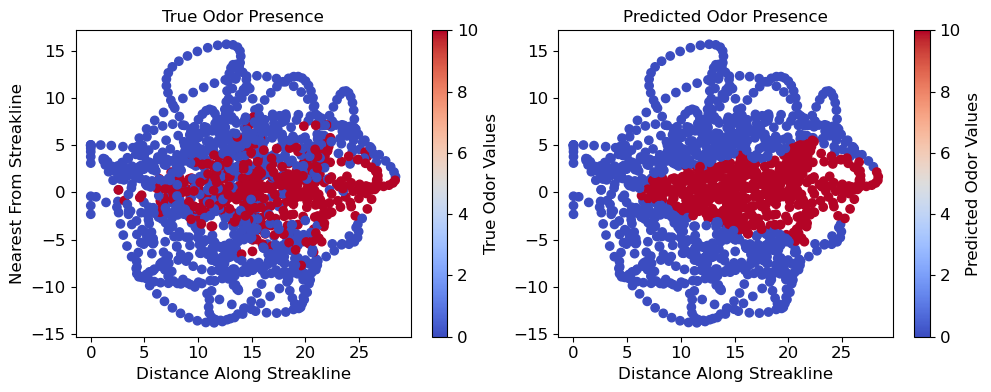

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Testing phase
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]
scaler = scalers[test_file_path]  # Retrieve the scaler for this model

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# Scale the test data using the scaler
X_test_scaled = scaler.transform(test_df[['distance_along_streakline', 'nearest_from_streakline']])

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_true = test_df['odor_binary'].values

# GP in eval mode
gp.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp(X_test_tensor)
    y_pred_mean = observed_pred.mean.cpu().numpy()
    y_pred_std = observed_pred.stddev.cpu().numpy()

y_pred_binary = np.where(y_pred_mean > 4, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")


f, axes = plt.subplots(1,2, figsize=(10, 4))

sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')


sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')
# axes[1].set_ylabel('Nearest From Streakline')

f.tight_layout()

mpl_functions.set_fontsize(f, 12)


#### Test on files it has not seen but same plume

Accuracy: 0.8112


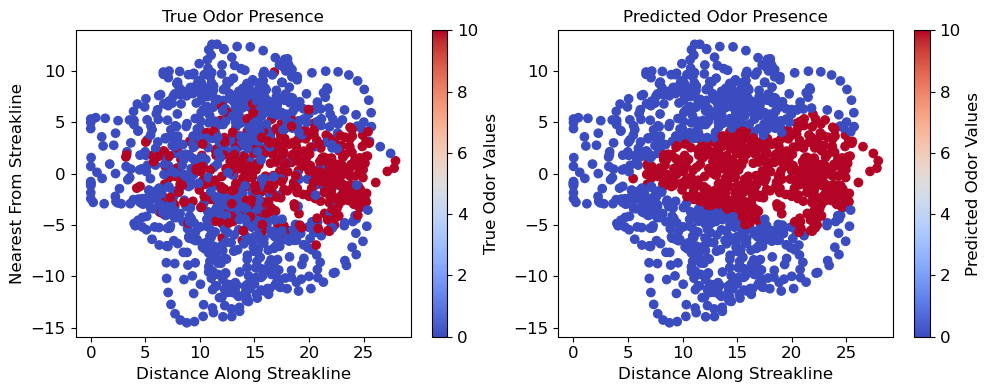

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5"
gp_representative = trained_models[representative_file_path].to(device)
scaler = scalers[representative_file_path]  # Retrieve the scaler for this model

test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag10.h5"
test_df = pd.read_hdf(test_file_path)

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test_scaled = scaler.transform(test_df[['distance_along_streakline', 'nearest_from_streakline']])

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_true = test_df['odor_binary'].values

# Predict using the GP model
gp_representative.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp_representative(X_test_tensor)
    y_pred_mean = observed_pred.mean.cpu().numpy()

y_pred_binary = np.where(y_pred_mean > 4, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Visualization
f, axes = plt.subplots(1, 2, figsize=(10, 4))
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()
mpl_functions.set_fontsize(f, 12)

### Continuous Value Predictions

In [3]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    df = pd.read_hdf(file_path)

    data_subsample = df.sample(frac=0.9)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor'].values

    n_splits = 5
    kf = KFold(n_splits=n_splits)

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)

    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        gp.fit(X_train, y_train)
        y_pred = gp.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))

    avg_mse = np.mean(mse_scores)
    print(f"Average MSE for {file_path}: {avg_mse}")
    gp.fit(X, y)
    
    return gp, file_path, avg_mse

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]


trained_models = {}
avg_mse_values = {}  

num_cores = 50  
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, file_path, avg_mse in results:
        trained_models[file_path] = gp_model
        avg_mse_values[file_path] = avg_mse 
for file_path, mse in avg_mse_values.items():
    print(f"Average MSE for {file_path}: {mse}")

print("Training Complete")


/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_proc

Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag12.h5: 3.586031610861233e-05


/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_proces

Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag48.h5: 0.7203216001254225


/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag52.h5: 0.12564173870137235
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag29.h5: 0.31335202593075523
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag6.h5: 0.14786146917386128
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag13.h5: 0.4728073981606277
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag32.h5: 0.13773234745140284
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag49.h5: 0.9969554555543014
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5: 0.18978695189379138
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag18.h5: 0.2964553664353542


/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag58.h5: 0.09347980857612159


/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag33.h5: 0.5871514263759652
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag19.h5: 0.35852238080504517
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag20.h5: 0.13314223575313686
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag46.h5: 0.19821077264245646
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag25.h5: 0.08232044681157817
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5: 0.7653217044403233


/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag38.h5: 0.17877148610845242
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag60.h5: 0.10654448739246654
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag50.h5: 0.4398017202659439
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag31.h5: 0.15062196240619274
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag43.h5: 0.2410195540891869
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag36.h5: 0.41179557555407015


/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag8.h5: 0.1254150322703424
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag59.h5: 0.10492886829823087
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag34.h5: 0.09536565942895178
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag47.h5: 0.06611701054216108
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag28.h5: 0.1376567910548953
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag22.h5: 0.32925276257322633
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag2.h5: 0.14367867046292288
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag15.h5: 0.13859775617610068
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag41.h5: 0.12402203358441351
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag7.h5: 0.17036103599471425
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag23.h5: 0.

/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag53.h5: 0.14124084210384794
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag57.h5: 0.28776485917203265


/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag9.h5: 0.07283861324736193
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag56.h5: 0.4012991195864627
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag24.h5: 0.09763825852749149


/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag40.h5: 0.11636081819289587
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag45.h5: 0.177387808822474
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag55.h5: 0.11408936586948917
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag54.h5: 0.11584882523688186
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag44.h5: 0.13037064888657604
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag4.h5: 0.840750498893876
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag37.h5: 0.12866036882304577
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag35.h5: 0.18857600054029486
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag51.h5: 0.12449505262191138
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag16.h5: 0.23280204512496505
Average MSE for /home/beast/An/data/Sept13Plumes/plume1/train/diag3.h5: 0.2

In [8]:
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag29.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor'].values  # Use continuous odor values

# Make predictions using the retrieved GP model
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)

# Regression Metrics
mse = mean_squared_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred_mean)
r2 = r2_score(y_true, y_pred_mean)

# Printing the Metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.03358303194533426
Root Mean Squared Error: 0.18325673778973112
Mean Absolute Error: 0.04100146842794842
R-squared: 0.8778921586677655


Text(0.5, 0, 'Distance Along Streakline')

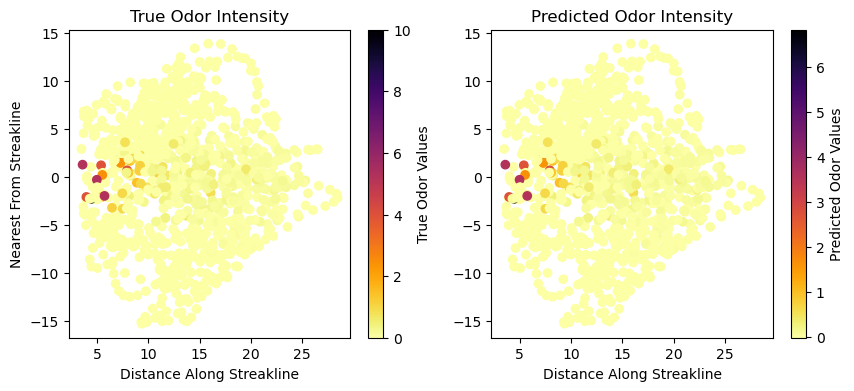

In [9]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno_r')  # Use actual odor values
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_mean, cmap='inferno_r')  # Use continuous predicted values
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

In [ ]:
# import matplotlib.patches as patches
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# df = pd.read_hdf("/home/beast/An/data/Sept13Plumes/plume1/train/diag19.h5")

# window_size_x = 5 
# step_size = 1
# x_min, x_max = df['distance_along_streakline'].min(), df['distance_along_streakline'].max()
# y_min, y_max = df['nearest_from_streakline'].min(), df['nearest_from_streakline'].max()

# fig, ax = plt.subplots(1, figsize=(4, 4))
# sc=ax.scatter(df.distance_along_streakline, df.nearest_from_streakline, c = df.odor, cmap= 'inferno', alpha=0.5)
# ax.set_xlim(-1, x_max+1)

# ax.set_ylim(-20,20)
# cbar = plt.colorbar(sc, ax=ax)

# rect = patches.Rectangle((x_min, y_min), window_size_x, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# ax.set_xlabel('Distance Along Streakline')
# ax.set_ylabel('Nearest From Streakline')
# ax.set_title('Sliding Window Across Data')


# def animate(i):
#     x_start = x_min + i * step_size
#     rect.set_x(x_start) 
#     return rect,

# fig.tight_layout()
# anim = FuncAnimation(fig, animate, frames=int((x_max - x_min) / step_size), interval=200, blit=True)

# HTML(anim.to_jshtml())
# anim.save('../sliding_window.gif', writer='imagemagick', fps=5)